##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 훈련 후 정수 양자화

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_integer_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lite/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

## 개요

정수 양자화는 32bit 부동 소수점 숫자(예: 가중치 및 활성화 출력)를 가장 가까운 8bit 고정 소수점 숫자로 변환하는 최적화 전략입니다. 그 결과 모델이 작아지고 추론 속도가 증가하여 [마이크로 컨트롤러](https://www.tensorflow.org/lite/microcontrollers)와 같은 저전력 장치에 유용합니다. 이 데이터 형식은 [에지 TPU](https://coral.ai/)와 같은 정수 전용 가속기에도 필요합니다.

이 가이드에서는 MNIST 모델을 처음부터 훈련하고 Tensorflow Lite 파일로 변환하고 [훈련 후 양자화](https://www.tensorflow.org/lite/performance/post_training_quantization)로 양자화합니다. 마지막으로 변환된 모델의 정확성을 확인하고 원본 부동 모델과 비교합니다.

실제로 모델을 양자화하려는 정도에 대한 몇 가지 옵션이 있습니다. 이 튜토리얼에서는 모든 가중치와 활성화 출력을 8bit 정수 데이터로 변환하는 '전체 정수 양자화'를 수행합니다. 반면 다른 전략은 일부 양의 데이터를 부동 소수점에 남길 수 있습니다.

다양한 양자화 전략에 대해 자세히 알아 보려면 [TensorFlow Lite 모델 최적화](https://www.tensorflow.org/lite/performance/model_optimization)에 대해 읽어보세요.


## 설정

입력 및 출력 텐서를 양자화하려면 TensorFlow r2.3에 추가된 API를 사용해야 합니다.

In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
print("TensorFlow version: ", tf.__version__)

2022-12-15 01:00:30.496669: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-15 01:00:30.496758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-15 01:00:30.496767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


TensorFlow version:  2.11.0


## TensorFlow 모델 생성하기

[MNIST 데이터세트](https://www.tensorflow.org/datasets/catalog/mnist)에서 숫자를 분류하는 간단한 모델을 만들어 보겠습니다.

이 훈련은 약 ~98%의 정확성으로 훈련하는 단 5 epoch 동안 모델을 훈련하기 때문에 오래 걸리지 않을 것입니다.

In [3]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

Epoch 1/5


   1/1875 [..............................] - ETA: 1:19:24 - loss: 2.2965 - accuracy: 0.0625

  20/1875 [..............................] - ETA: 4s - loss: 2.1207 - accuracy: 0.3422     

  41/1875 [..............................] - ETA: 4s - loss: 1.8198 - accuracy: 0.5434

  63/1875 [>.............................] - ETA: 4s - loss: 1.4974 - accuracy: 0.6384

  85/1875 [>.............................] - ETA: 4s - loss: 1.2939 - accuracy: 0.6787

 105/1875 [>.............................] - ETA: 4s - loss: 1.1485 - accuracy: 0.7125

 125/1875 [=>............................] - ETA: 4s - loss: 1.0334 - accuracy: 0.7408

 146/1875 [=>............................] - ETA: 4s - loss: 0.9485 - accuracy: 0.7594

 167/1875 [=>............................] - ETA: 4s - loss: 0.8818 - accuracy: 0.7738

 188/1875 [==>...........................] - ETA: 4s - loss: 0.8302 - accuracy: 0.7856

 209/1875 [==>...........................] - ETA: 4s - loss: 0.7868 - accuracy: 0.7955

 230/1875 [==>...........................] - ETA: 4s - loss: 0.7521 - accuracy: 0.8052

 251/1875 [===>..........................] - ETA: 3s - loss: 0.7214 - accuracy: 0.8124

 272/1875 [===>..........................] - ETA: 3s - loss: 0.6906 - accuracy: 0.8202

 293/1875 [===>..........................] - ETA: 3s - loss: 0.6700 - accuracy: 0.8247

 315/1875 [====>.........................] - ETA: 3s - loss: 0.6452 - accuracy: 0.8300

 335/1875 [====>.........................] - ETA: 3s - loss: 0.6244 - accuracy: 0.8354

 356/1875 [====>.........................] - ETA: 3s - loss: 0.6043 - accuracy: 0.8402

 377/1875 [=====>........................] - ETA: 3s - loss: 0.5861 - accuracy: 0.8452

 399/1875 [=====>........................] - ETA: 3s - loss: 0.5691 - accuracy: 0.8493

 420/1875 [=====>........................] - ETA: 3s - loss: 0.5559 - accuracy: 0.8528

 442/1875 [======>.......................] - ETA: 3s - loss: 0.5450 - accuracy: 0.8549

 465/1875 [======>.......................] - ETA: 3s - loss: 0.5338 - accuracy: 0.8577

 487/1875 [======>.......................] - ETA: 3s - loss: 0.5216 - accuracy: 0.8602

 509/1875 [=======>......................] - ETA: 3s - loss: 0.5094 - accuracy: 0.8632

 530/1875 [=======>......................] - ETA: 3s - loss: 0.5005 - accuracy: 0.8653

 552/1875 [=======>......................] - ETA: 3s - loss: 0.4915 - accuracy: 0.8671

 573/1875 [========>.....................] - ETA: 3s - loss: 0.4829 - accuracy: 0.8696

 594/1875 [========>.....................] - ETA: 3s - loss: 0.4731 - accuracy: 0.8720

 615/1875 [========>.....................] - ETA: 3s - loss: 0.4639 - accuracy: 0.8746

 637/1875 [=========>....................] - ETA: 2s - loss: 0.4539 - accuracy: 0.8774

 658/1875 [=========>....................] - ETA: 2s - loss: 0.4474 - accuracy: 0.8789

 680/1875 [=========>....................] - ETA: 2s - loss: 0.4409 - accuracy: 0.8807

 701/1875 [==========>...................] - ETA: 2s - loss: 0.4353 - accuracy: 0.8819

 723/1875 [==========>...................] - ETA: 2s - loss: 0.4293 - accuracy: 0.8835

 744/1875 [==========>...................] - ETA: 2s - loss: 0.4246 - accuracy: 0.8847

 766/1875 [===========>..................] - ETA: 2s - loss: 0.4188 - accuracy: 0.8862

 787/1875 [===========>..................] - ETA: 2s - loss: 0.4135 - accuracy: 0.8875

 809/1875 [===========>..................] - ETA: 2s - loss: 0.4080 - accuracy: 0.8892

 831/1875 [============>.................] - ETA: 2s - loss: 0.4044 - accuracy: 0.8903

 852/1875 [============>.................] - ETA: 2s - loss: 0.4004 - accuracy: 0.8916

 874/1875 [============>.................] - ETA: 2s - loss: 0.3957 - accuracy: 0.8927

 896/1875 [=============>................] - ETA: 2s - loss: 0.3919 - accuracy: 0.8936

 917/1875 [=============>................] - ETA: 2s - loss: 0.3883 - accuracy: 0.8945

 939/1875 [==============>...............] - ETA: 2s - loss: 0.3844 - accuracy: 0.8955

 961/1875 [==============>...............] - ETA: 2s - loss: 0.3786 - accuracy: 0.8971

 982/1875 [==============>...............] - ETA: 2s - loss: 0.3745 - accuracy: 0.8979

1003/1875 [===============>..............] - ETA: 2s - loss: 0.3704 - accuracy: 0.8991

1024/1875 [===============>..............] - ETA: 2s - loss: 0.3666 - accuracy: 0.8998

1046/1875 [===============>..............] - ETA: 1s - loss: 0.3633 - accuracy: 0.9004

1067/1875 [================>.............] - ETA: 1s - loss: 0.3602 - accuracy: 0.9012

1088/1875 [================>.............] - ETA: 1s - loss: 0.3561 - accuracy: 0.9023

1110/1875 [================>.............] - ETA: 1s - loss: 0.3536 - accuracy: 0.9031

1131/1875 [=================>............] - ETA: 1s - loss: 0.3497 - accuracy: 0.9041

1153/1875 [=================>............] - ETA: 1s - loss: 0.3472 - accuracy: 0.9048

1174/1875 [=================>............] - ETA: 1s - loss: 0.3455 - accuracy: 0.9052

1196/1875 [==================>...........] - ETA: 1s - loss: 0.3422 - accuracy: 0.9061

1218/1875 [==================>...........] - ETA: 1s - loss: 0.3389 - accuracy: 0.9068

1240/1875 [==================>...........] - ETA: 1s - loss: 0.3351 - accuracy: 0.9078

1262/1875 [===================>..........] - ETA: 1s - loss: 0.3330 - accuracy: 0.9084

1284/1875 [===================>..........] - ETA: 1s - loss: 0.3300 - accuracy: 0.9091

1306/1875 [===================>..........] - ETA: 1s - loss: 0.3275 - accuracy: 0.9097

1328/1875 [====================>.........] - ETA: 1s - loss: 0.3251 - accuracy: 0.9104

1350/1875 [====================>.........] - ETA: 1s - loss: 0.3227 - accuracy: 0.9110

1372/1875 [====================>.........] - ETA: 1s - loss: 0.3210 - accuracy: 0.9115

1394/1875 [=====================>........] - ETA: 1s - loss: 0.3178 - accuracy: 0.9125

1415/1875 [=====================>........] - ETA: 1s - loss: 0.3157 - accuracy: 0.9131

1437/1875 [=====================>........] - ETA: 1s - loss: 0.3136 - accuracy: 0.9137

1459/1875 [======================>.......] - ETA: 0s - loss: 0.3110 - accuracy: 0.9143

1480/1875 [======================>.......] - ETA: 0s - loss: 0.3091 - accuracy: 0.9147

1502/1875 [=======================>......] - ETA: 0s - loss: 0.3065 - accuracy: 0.9154

1524/1875 [=======================>......] - ETA: 0s - loss: 0.3041 - accuracy: 0.9160

1545/1875 [=======================>......] - ETA: 0s - loss: 0.3015 - accuracy: 0.9168

1566/1875 [========================>.....] - ETA: 0s - loss: 0.2992 - accuracy: 0.9174

1587/1875 [========================>.....] - ETA: 0s - loss: 0.2976 - accuracy: 0.9176

1608/1875 [========================>.....] - ETA: 0s - loss: 0.2962 - accuracy: 0.9180

1630/1875 [=========================>....] - ETA: 0s - loss: 0.2945 - accuracy: 0.9183

1652/1875 [=========================>....] - ETA: 0s - loss: 0.2926 - accuracy: 0.9189

1674/1875 [=========================>....] - ETA: 0s - loss: 0.2908 - accuracy: 0.9194

1696/1875 [==========================>...] - ETA: 0s - loss: 0.2891 - accuracy: 0.9198

1717/1875 [==========================>...] - ETA: 0s - loss: 0.2876 - accuracy: 0.9202

1738/1875 [==========================>...] - ETA: 0s - loss: 0.2854 - accuracy: 0.9208

1759/1875 [===========================>..] - ETA: 0s - loss: 0.2842 - accuracy: 0.9212

1780/1875 [===========================>..] - ETA: 0s - loss: 0.2828 - accuracy: 0.9215

1801/1875 [===========================>..] - ETA: 0s - loss: 0.2810 - accuracy: 0.9220

1823/1875 [============================>.] - ETA: 0s - loss: 0.2794 - accuracy: 0.9223

1845/1875 [============================>.] - ETA: 0s - loss: 0.2778 - accuracy: 0.9227

1866/1875 [============================>.] - ETA: 0s - loss: 0.2765 - accuracy: 0.9231

1875/1875 [==============================] - 8s 3ms/step - loss: 0.2758 - accuracy: 0.9233 - val_loss: 0.1289 - val_accuracy: 0.9633


Epoch 2/5


   1/1875 [..............................] - ETA: 6s - loss: 0.0593 - accuracy: 1.0000

  22/1875 [..............................] - ETA: 4s - loss: 0.1142 - accuracy: 0.9716

  44/1875 [..............................] - ETA: 4s - loss: 0.1225 - accuracy: 0.9702

  66/1875 [>.............................] - ETA: 4s - loss: 0.1220 - accuracy: 0.9683

  88/1875 [>.............................] - ETA: 4s - loss: 0.1287 - accuracy: 0.9652

 110/1875 [>.............................] - ETA: 4s - loss: 0.1271 - accuracy: 0.9659

 132/1875 [=>............................] - ETA: 4s - loss: 0.1255 - accuracy: 0.9647

 154/1875 [=>............................] - ETA: 4s - loss: 0.1258 - accuracy: 0.9641

 176/1875 [=>............................] - ETA: 3s - loss: 0.1262 - accuracy: 0.9640

 198/1875 [==>...........................] - ETA: 3s - loss: 0.1236 - accuracy: 0.9650

 220/1875 [==>...........................] - ETA: 3s - loss: 0.1226 - accuracy: 0.9656

 242/1875 [==>...........................] - ETA: 3s - loss: 0.1225 - accuracy: 0.9658

 264/1875 [===>..........................] - ETA: 3s - loss: 0.1221 - accuracy: 0.9657

 286/1875 [===>..........................] - ETA: 3s - loss: 0.1224 - accuracy: 0.9653

 308/1875 [===>..........................] - ETA: 3s - loss: 0.1238 - accuracy: 0.9649

 329/1875 [====>.........................] - ETA: 3s - loss: 0.1258 - accuracy: 0.9644

 350/1875 [====>.........................] - ETA: 3s - loss: 0.1267 - accuracy: 0.9642

 372/1875 [====>.........................] - ETA: 3s - loss: 0.1271 - accuracy: 0.9640

 394/1875 [=====>........................] - ETA: 3s - loss: 0.1272 - accuracy: 0.9638

 416/1875 [=====>........................] - ETA: 3s - loss: 0.1289 - accuracy: 0.9636

 438/1875 [======>.......................] - ETA: 3s - loss: 0.1274 - accuracy: 0.9642

 459/1875 [======>.......................] - ETA: 3s - loss: 0.1260 - accuracy: 0.9643

 480/1875 [======>.......................] - ETA: 3s - loss: 0.1267 - accuracy: 0.9643

 501/1875 [=======>......................] - ETA: 3s - loss: 0.1254 - accuracy: 0.9646

 522/1875 [=======>......................] - ETA: 3s - loss: 0.1260 - accuracy: 0.9643

 543/1875 [=======>......................] - ETA: 3s - loss: 0.1260 - accuracy: 0.9642

 564/1875 [========>.....................] - ETA: 3s - loss: 0.1256 - accuracy: 0.9645

 585/1875 [========>.....................] - ETA: 3s - loss: 0.1245 - accuracy: 0.9647

 606/1875 [========>.....................] - ETA: 3s - loss: 0.1248 - accuracy: 0.9646

 627/1875 [=========>....................] - ETA: 2s - loss: 0.1242 - accuracy: 0.9649

 649/1875 [=========>....................] - ETA: 2s - loss: 0.1237 - accuracy: 0.9649

 671/1875 [=========>....................] - ETA: 2s - loss: 0.1241 - accuracy: 0.9650

 693/1875 [==========>...................] - ETA: 2s - loss: 0.1229 - accuracy: 0.9652

 715/1875 [==========>...................] - ETA: 2s - loss: 0.1224 - accuracy: 0.9653

 736/1875 [==========>...................] - ETA: 2s - loss: 0.1225 - accuracy: 0.9651

 757/1875 [===========>..................] - ETA: 2s - loss: 0.1222 - accuracy: 0.9653

 778/1875 [===========>..................] - ETA: 2s - loss: 0.1217 - accuracy: 0.9655

 800/1875 [===========>..................] - ETA: 2s - loss: 0.1213 - accuracy: 0.9658

 821/1875 [============>.................] - ETA: 2s - loss: 0.1217 - accuracy: 0.9657

 842/1875 [============>.................] - ETA: 2s - loss: 0.1219 - accuracy: 0.9654

 863/1875 [============>.................] - ETA: 2s - loss: 0.1226 - accuracy: 0.9652

 884/1875 [=============>................] - ETA: 2s - loss: 0.1222 - accuracy: 0.9654

 905/1875 [=============>................] - ETA: 2s - loss: 0.1213 - accuracy: 0.9655

 926/1875 [=============>................] - ETA: 2s - loss: 0.1205 - accuracy: 0.9656

 947/1875 [==============>...............] - ETA: 2s - loss: 0.1208 - accuracy: 0.9657

 968/1875 [==============>...............] - ETA: 2s - loss: 0.1207 - accuracy: 0.9658

 989/1875 [==============>...............] - ETA: 2s - loss: 0.1209 - accuracy: 0.9658

1011/1875 [===============>..............] - ETA: 2s - loss: 0.1204 - accuracy: 0.9658

1032/1875 [===============>..............] - ETA: 2s - loss: 0.1202 - accuracy: 0.9658

1053/1875 [===============>..............] - ETA: 1s - loss: 0.1197 - accuracy: 0.9661

1075/1875 [================>.............] - ETA: 1s - loss: 0.1190 - accuracy: 0.9664

1097/1875 [================>.............] - ETA: 1s - loss: 0.1189 - accuracy: 0.9663

1119/1875 [================>.............] - ETA: 1s - loss: 0.1189 - accuracy: 0.9663

1140/1875 [=================>............] - ETA: 1s - loss: 0.1190 - accuracy: 0.9663

1162/1875 [=================>............] - ETA: 1s - loss: 0.1189 - accuracy: 0.9664

1184/1875 [=================>............] - ETA: 1s - loss: 0.1184 - accuracy: 0.9666

1206/1875 [==================>...........] - ETA: 1s - loss: 0.1184 - accuracy: 0.9667

1228/1875 [==================>...........] - ETA: 1s - loss: 0.1184 - accuracy: 0.9666

1250/1875 [===================>..........] - ETA: 1s - loss: 0.1179 - accuracy: 0.9667

1272/1875 [===================>..........] - ETA: 1s - loss: 0.1179 - accuracy: 0.9667

1293/1875 [===================>..........] - ETA: 1s - loss: 0.1176 - accuracy: 0.9668

1315/1875 [====================>.........] - ETA: 1s - loss: 0.1180 - accuracy: 0.9667

1337/1875 [====================>.........] - ETA: 1s - loss: 0.1178 - accuracy: 0.9668

1359/1875 [====================>.........] - ETA: 1s - loss: 0.1172 - accuracy: 0.9668

1381/1875 [=====================>........] - ETA: 1s - loss: 0.1174 - accuracy: 0.9668

1402/1875 [=====================>........] - ETA: 1s - loss: 0.1175 - accuracy: 0.9668

1423/1875 [=====================>........] - ETA: 1s - loss: 0.1171 - accuracy: 0.9669

1444/1875 [======================>.......] - ETA: 1s - loss: 0.1172 - accuracy: 0.9668

1465/1875 [======================>.......] - ETA: 0s - loss: 0.1170 - accuracy: 0.9668

1487/1875 [======================>.......] - ETA: 0s - loss: 0.1173 - accuracy: 0.9667

1509/1875 [=======================>......] - ETA: 0s - loss: 0.1167 - accuracy: 0.9668

1531/1875 [=======================>......] - ETA: 0s - loss: 0.1168 - accuracy: 0.9669

1553/1875 [=======================>......] - ETA: 0s - loss: 0.1167 - accuracy: 0.9669

1575/1875 [========================>.....] - ETA: 0s - loss: 0.1165 - accuracy: 0.9670

1596/1875 [========================>.....] - ETA: 0s - loss: 0.1162 - accuracy: 0.9671

1617/1875 [========================>.....] - ETA: 0s - loss: 0.1157 - accuracy: 0.9672

1638/1875 [=========================>....] - ETA: 0s - loss: 0.1156 - accuracy: 0.9672

1660/1875 [=========================>....] - ETA: 0s - loss: 0.1151 - accuracy: 0.9674

1680/1875 [=========================>....] - ETA: 0s - loss: 0.1148 - accuracy: 0.9674

1700/1875 [==========================>...] - ETA: 0s - loss: 0.1148 - accuracy: 0.9674

1721/1875 [==========================>...] - ETA: 0s - loss: 0.1148 - accuracy: 0.9674

1743/1875 [==========================>...] - ETA: 0s - loss: 0.1145 - accuracy: 0.9674

1765/1875 [===========================>..] - ETA: 0s - loss: 0.1139 - accuracy: 0.9676

1787/1875 [===========================>..] - ETA: 0s - loss: 0.1134 - accuracy: 0.9676

1808/1875 [===========================>..] - ETA: 0s - loss: 0.1133 - accuracy: 0.9676

1829/1875 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9677

1850/1875 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9677

1871/1875 [============================>.] - ETA: 0s - loss: 0.1128 - accuracy: 0.9678

1875/1875 [==============================] - 5s 3ms/step - loss: 0.1128 - accuracy: 0.9679 - val_loss: 0.0919 - val_accuracy: 0.9721


Epoch 3/5


   1/1875 [..............................] - ETA: 6s - loss: 0.0611 - accuracy: 1.0000

  22/1875 [..............................] - ETA: 4s - loss: 0.0925 - accuracy: 0.9744

  44/1875 [..............................] - ETA: 4s - loss: 0.0811 - accuracy: 0.9780

  66/1875 [>.............................] - ETA: 4s - loss: 0.0746 - accuracy: 0.9792

  87/1875 [>.............................] - ETA: 4s - loss: 0.0800 - accuracy: 0.9763

 108/1875 [>.............................] - ETA: 4s - loss: 0.0802 - accuracy: 0.9771

 129/1875 [=>............................] - ETA: 4s - loss: 0.0854 - accuracy: 0.9760

 150/1875 [=>............................] - ETA: 4s - loss: 0.0827 - accuracy: 0.9765

 171/1875 [=>............................] - ETA: 4s - loss: 0.0863 - accuracy: 0.9740

 192/1875 [==>...........................] - ETA: 4s - loss: 0.0851 - accuracy: 0.9740

 215/1875 [==>...........................] - ETA: 3s - loss: 0.0864 - accuracy: 0.9741

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0905 - accuracy: 0.9733

 260/1875 [===>..........................] - ETA: 3s - loss: 0.0921 - accuracy: 0.9733

 281/1875 [===>..........................] - ETA: 3s - loss: 0.0909 - accuracy: 0.9734

 302/1875 [===>..........................] - ETA: 3s - loss: 0.0923 - accuracy: 0.9731

 322/1875 [====>.........................] - ETA: 3s - loss: 0.0914 - accuracy: 0.9733

 343/1875 [====>.........................] - ETA: 3s - loss: 0.0933 - accuracy: 0.9727

 363/1875 [====>.........................] - ETA: 3s - loss: 0.0934 - accuracy: 0.9726

 382/1875 [=====>........................] - ETA: 3s - loss: 0.0923 - accuracy: 0.9729

 403/1875 [=====>........................] - ETA: 3s - loss: 0.0925 - accuracy: 0.9730

 425/1875 [=====>........................] - ETA: 3s - loss: 0.0922 - accuracy: 0.9732

 447/1875 [======>.......................] - ETA: 3s - loss: 0.0924 - accuracy: 0.9731

 468/1875 [======>.......................] - ETA: 3s - loss: 0.0927 - accuracy: 0.9731

 490/1875 [======>.......................] - ETA: 3s - loss: 0.0923 - accuracy: 0.9729

 511/1875 [=======>......................] - ETA: 3s - loss: 0.0923 - accuracy: 0.9731

 532/1875 [=======>......................] - ETA: 3s - loss: 0.0929 - accuracy: 0.9729

 553/1875 [=======>......................] - ETA: 3s - loss: 0.0926 - accuracy: 0.9730

 575/1875 [========>.....................] - ETA: 3s - loss: 0.0930 - accuracy: 0.9726

 596/1875 [========>.....................] - ETA: 3s - loss: 0.0935 - accuracy: 0.9722

 617/1875 [========>.....................] - ETA: 3s - loss: 0.0931 - accuracy: 0.9723

 638/1875 [=========>....................] - ETA: 2s - loss: 0.0936 - accuracy: 0.9722

 660/1875 [=========>....................] - ETA: 2s - loss: 0.0927 - accuracy: 0.9726

 682/1875 [=========>....................] - ETA: 2s - loss: 0.0929 - accuracy: 0.9724

 704/1875 [==========>...................] - ETA: 2s - loss: 0.0923 - accuracy: 0.9726

 726/1875 [==========>...................] - ETA: 2s - loss: 0.0925 - accuracy: 0.9726

 747/1875 [==========>...................] - ETA: 2s - loss: 0.0924 - accuracy: 0.9727

 769/1875 [===========>..................] - ETA: 2s - loss: 0.0918 - accuracy: 0.9728

 792/1875 [===========>..................] - ETA: 2s - loss: 0.0909 - accuracy: 0.9731

 814/1875 [============>.................] - ETA: 2s - loss: 0.0908 - accuracy: 0.9728

 836/1875 [============>.................] - ETA: 2s - loss: 0.0911 - accuracy: 0.9727

 858/1875 [============>.................] - ETA: 2s - loss: 0.0910 - accuracy: 0.9728

 880/1875 [=============>................] - ETA: 2s - loss: 0.0910 - accuracy: 0.9728

 902/1875 [=============>................] - ETA: 2s - loss: 0.0915 - accuracy: 0.9727

 924/1875 [=============>................] - ETA: 2s - loss: 0.0915 - accuracy: 0.9727

 946/1875 [==============>...............] - ETA: 2s - loss: 0.0913 - accuracy: 0.9728

 968/1875 [==============>...............] - ETA: 2s - loss: 0.0910 - accuracy: 0.9731

 990/1875 [==============>...............] - ETA: 2s - loss: 0.0910 - accuracy: 0.9731

1012/1875 [===============>..............] - ETA: 2s - loss: 0.0911 - accuracy: 0.9733

1033/1875 [===============>..............] - ETA: 2s - loss: 0.0906 - accuracy: 0.9733

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0902 - accuracy: 0.9735

1077/1875 [================>.............] - ETA: 1s - loss: 0.0903 - accuracy: 0.9735

1099/1875 [================>.............] - ETA: 1s - loss: 0.0899 - accuracy: 0.9737

1121/1875 [================>.............] - ETA: 1s - loss: 0.0895 - accuracy: 0.9738

1142/1875 [=================>............] - ETA: 1s - loss: 0.0893 - accuracy: 0.9738

1163/1875 [=================>............] - ETA: 1s - loss: 0.0896 - accuracy: 0.9738

1185/1875 [=================>............] - ETA: 1s - loss: 0.0894 - accuracy: 0.9738

1207/1875 [==================>...........] - ETA: 1s - loss: 0.0895 - accuracy: 0.9736

1229/1875 [==================>...........] - ETA: 1s - loss: 0.0900 - accuracy: 0.9736

1251/1875 [===================>..........] - ETA: 1s - loss: 0.0897 - accuracy: 0.9738

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0893 - accuracy: 0.9740

1294/1875 [===================>..........] - ETA: 1s - loss: 0.0890 - accuracy: 0.9740

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0890 - accuracy: 0.9742

1336/1875 [====================>.........] - ETA: 1s - loss: 0.0889 - accuracy: 0.9742

1358/1875 [====================>.........] - ETA: 1s - loss: 0.0886 - accuracy: 0.9743

1379/1875 [=====================>........] - ETA: 1s - loss: 0.0884 - accuracy: 0.9744

1401/1875 [=====================>........] - ETA: 1s - loss: 0.0880 - accuracy: 0.9746

1423/1875 [=====================>........] - ETA: 1s - loss: 0.0877 - accuracy: 0.9746

1445/1875 [======================>.......] - ETA: 1s - loss: 0.0878 - accuracy: 0.9745

1466/1875 [======================>.......] - ETA: 0s - loss: 0.0875 - accuracy: 0.9746

1488/1875 [======================>.......] - ETA: 0s - loss: 0.0871 - accuracy: 0.9747

1509/1875 [=======================>......] - ETA: 0s - loss: 0.0871 - accuracy: 0.9748

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0872 - accuracy: 0.9748

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0872 - accuracy: 0.9748

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0871 - accuracy: 0.9747

1595/1875 [========================>.....] - ETA: 0s - loss: 0.0867 - accuracy: 0.9748

1616/1875 [========================>.....] - ETA: 0s - loss: 0.0866 - accuracy: 0.9748

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0865 - accuracy: 0.9749

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0861 - accuracy: 0.9750

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0864 - accuracy: 0.9749

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0861 - accuracy: 0.9749

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0860 - accuracy: 0.9750

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0859 - accuracy: 0.9751

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0858 - accuracy: 0.9750

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0857 - accuracy: 0.9751

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0855 - accuracy: 0.9752

1828/1875 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9752

1851/1875 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9753

1873/1875 [============================>.] - ETA: 0s - loss: 0.0851 - accuracy: 0.9753

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0850 - accuracy: 0.9753 - val_loss: 0.0745 - val_accuracy: 0.9779


Epoch 4/5


   1/1875 [..............................] - ETA: 7s - loss: 0.0068 - accuracy: 1.0000

  22/1875 [..............................] - ETA: 4s - loss: 0.0600 - accuracy: 0.9759

  43/1875 [..............................] - ETA: 4s - loss: 0.0672 - accuracy: 0.9782

  64/1875 [>.............................] - ETA: 4s - loss: 0.0729 - accuracy: 0.9761

  85/1875 [>.............................] - ETA: 4s - loss: 0.0701 - accuracy: 0.9765

 107/1875 [>.............................] - ETA: 4s - loss: 0.0740 - accuracy: 0.9766

 129/1875 [=>............................] - ETA: 4s - loss: 0.0701 - accuracy: 0.9784

 150/1875 [=>............................] - ETA: 4s - loss: 0.0715 - accuracy: 0.9792

 171/1875 [=>............................] - ETA: 4s - loss: 0.0699 - accuracy: 0.9799

 193/1875 [==>...........................] - ETA: 4s - loss: 0.0717 - accuracy: 0.9794

 215/1875 [==>...........................] - ETA: 3s - loss: 0.0701 - accuracy: 0.9797

 236/1875 [==>...........................] - ETA: 3s - loss: 0.0718 - accuracy: 0.9792

 257/1875 [===>..........................] - ETA: 3s - loss: 0.0715 - accuracy: 0.9787

 279/1875 [===>..........................] - ETA: 3s - loss: 0.0724 - accuracy: 0.9786

 301/1875 [===>..........................] - ETA: 3s - loss: 0.0734 - accuracy: 0.9782

 323/1875 [====>.........................] - ETA: 3s - loss: 0.0738 - accuracy: 0.9783

 345/1875 [====>.........................] - ETA: 3s - loss: 0.0752 - accuracy: 0.9784

 367/1875 [====>.........................] - ETA: 3s - loss: 0.0748 - accuracy: 0.9784

 389/1875 [=====>........................] - ETA: 3s - loss: 0.0753 - accuracy: 0.9784

 411/1875 [=====>........................] - ETA: 3s - loss: 0.0755 - accuracy: 0.9783

 434/1875 [=====>........................] - ETA: 3s - loss: 0.0760 - accuracy: 0.9780

 456/1875 [======>.......................] - ETA: 3s - loss: 0.0752 - accuracy: 0.9783

 478/1875 [======>.......................] - ETA: 3s - loss: 0.0742 - accuracy: 0.9787

 500/1875 [=======>......................] - ETA: 3s - loss: 0.0742 - accuracy: 0.9787

 523/1875 [=======>......................] - ETA: 3s - loss: 0.0732 - accuracy: 0.9790

 546/1875 [=======>......................] - ETA: 3s - loss: 0.0724 - accuracy: 0.9792

 569/1875 [========>.....................] - ETA: 3s - loss: 0.0724 - accuracy: 0.9792

 591/1875 [========>.....................] - ETA: 3s - loss: 0.0717 - accuracy: 0.9794

 613/1875 [========>.....................] - ETA: 2s - loss: 0.0717 - accuracy: 0.9793

 635/1875 [=========>....................] - ETA: 2s - loss: 0.0719 - accuracy: 0.9792

 657/1875 [=========>....................] - ETA: 2s - loss: 0.0713 - accuracy: 0.9794

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0718 - accuracy: 0.9792

 701/1875 [==========>...................] - ETA: 2s - loss: 0.0720 - accuracy: 0.9791

 723/1875 [==========>...................] - ETA: 2s - loss: 0.0725 - accuracy: 0.9789

 745/1875 [==========>...................] - ETA: 2s - loss: 0.0735 - accuracy: 0.9786

 767/1875 [===========>..................] - ETA: 2s - loss: 0.0734 - accuracy: 0.9787

 789/1875 [===========>..................] - ETA: 2s - loss: 0.0727 - accuracy: 0.9789

 812/1875 [===========>..................] - ETA: 2s - loss: 0.0729 - accuracy: 0.9787

 834/1875 [============>.................] - ETA: 2s - loss: 0.0734 - accuracy: 0.9784

 856/1875 [============>.................] - ETA: 2s - loss: 0.0733 - accuracy: 0.9782

 878/1875 [=============>................] - ETA: 2s - loss: 0.0736 - accuracy: 0.9783

 900/1875 [=============>................] - ETA: 2s - loss: 0.0739 - accuracy: 0.9781

 921/1875 [=============>................] - ETA: 2s - loss: 0.0735 - accuracy: 0.9783

 943/1875 [==============>...............] - ETA: 2s - loss: 0.0733 - accuracy: 0.9783

 964/1875 [==============>...............] - ETA: 2s - loss: 0.0733 - accuracy: 0.9783

 986/1875 [==============>...............] - ETA: 2s - loss: 0.0731 - accuracy: 0.9783

1009/1875 [===============>..............] - ETA: 2s - loss: 0.0734 - accuracy: 0.9783

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0732 - accuracy: 0.9782

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0731 - accuracy: 0.9783

1072/1875 [================>.............] - ETA: 1s - loss: 0.0732 - accuracy: 0.9782

1093/1875 [================>.............] - ETA: 1s - loss: 0.0732 - accuracy: 0.9782

1115/1875 [================>.............] - ETA: 1s - loss: 0.0728 - accuracy: 0.9783

1136/1875 [=================>............] - ETA: 1s - loss: 0.0727 - accuracy: 0.9784

1157/1875 [=================>............] - ETA: 1s - loss: 0.0727 - accuracy: 0.9783

1179/1875 [=================>............] - ETA: 1s - loss: 0.0720 - accuracy: 0.9785

1200/1875 [==================>...........] - ETA: 1s - loss: 0.0717 - accuracy: 0.9786

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0717 - accuracy: 0.9787

1243/1875 [==================>...........] - ETA: 1s - loss: 0.0714 - accuracy: 0.9788

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0713 - accuracy: 0.9788

1287/1875 [===================>..........] - ETA: 1s - loss: 0.0713 - accuracy: 0.9789

1309/1875 [===================>..........] - ETA: 1s - loss: 0.0715 - accuracy: 0.9787

1331/1875 [====================>.........] - ETA: 1s - loss: 0.0713 - accuracy: 0.9788

1353/1875 [====================>.........] - ETA: 1s - loss: 0.0710 - accuracy: 0.9789

1376/1875 [=====================>........] - ETA: 1s - loss: 0.0709 - accuracy: 0.9789

1398/1875 [=====================>........] - ETA: 1s - loss: 0.0711 - accuracy: 0.9788

1420/1875 [=====================>........] - ETA: 1s - loss: 0.0713 - accuracy: 0.9787

1441/1875 [======================>.......] - ETA: 1s - loss: 0.0710 - accuracy: 0.9788

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0707 - accuracy: 0.9788

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0705 - accuracy: 0.9789

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0707 - accuracy: 0.9788

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0709 - accuracy: 0.9789

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0712 - accuracy: 0.9788

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0713 - accuracy: 0.9787

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0715 - accuracy: 0.9788

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0713 - accuracy: 0.9789

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0714 - accuracy: 0.9788

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0716 - accuracy: 0.9786

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0715 - accuracy: 0.9786

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0715 - accuracy: 0.9786

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0715 - accuracy: 0.9787

1744/1875 [==========================>...] - ETA: 0s - loss: 0.0717 - accuracy: 0.9787

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0715 - accuracy: 0.9788

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0714 - accuracy: 0.9787

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0715 - accuracy: 0.9788

1830/1875 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9789

1852/1875 [============================>.] - ETA: 0s - loss: 0.0712 - accuracy: 0.9789

1873/1875 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9789

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0714 - accuracy: 0.9789 - val_loss: 0.0704 - val_accuracy: 0.9765


Epoch 5/5


   1/1875 [..............................] - ETA: 6s - loss: 0.0315 - accuracy: 1.0000

  22/1875 [..............................] - ETA: 4s - loss: 0.0612 - accuracy: 0.9830

  44/1875 [..............................] - ETA: 4s - loss: 0.0612 - accuracy: 0.9780

  66/1875 [>.............................] - ETA: 4s - loss: 0.0582 - accuracy: 0.9811

  88/1875 [>.............................] - ETA: 4s - loss: 0.0613 - accuracy: 0.9808

 110/1875 [>.............................] - ETA: 4s - loss: 0.0635 - accuracy: 0.9807

 131/1875 [=>............................] - ETA: 4s - loss: 0.0602 - accuracy: 0.9812

 153/1875 [=>............................] - ETA: 4s - loss: 0.0592 - accuracy: 0.9820

 175/1875 [=>............................] - ETA: 4s - loss: 0.0596 - accuracy: 0.9814

 197/1875 [==>...........................] - ETA: 3s - loss: 0.0571 - accuracy: 0.9822

 218/1875 [==>...........................] - ETA: 3s - loss: 0.0558 - accuracy: 0.9829

 240/1875 [==>...........................] - ETA: 3s - loss: 0.0578 - accuracy: 0.9820

 262/1875 [===>..........................] - ETA: 3s - loss: 0.0564 - accuracy: 0.9827

 284/1875 [===>..........................] - ETA: 3s - loss: 0.0565 - accuracy: 0.9831

 306/1875 [===>..........................] - ETA: 3s - loss: 0.0574 - accuracy: 0.9829

 327/1875 [====>.........................] - ETA: 3s - loss: 0.0566 - accuracy: 0.9831

 348/1875 [====>.........................] - ETA: 3s - loss: 0.0578 - accuracy: 0.9827

 370/1875 [====>.........................] - ETA: 3s - loss: 0.0569 - accuracy: 0.9826

 392/1875 [=====>........................] - ETA: 3s - loss: 0.0572 - accuracy: 0.9825

 414/1875 [=====>........................] - ETA: 3s - loss: 0.0577 - accuracy: 0.9825

 436/1875 [=====>........................] - ETA: 3s - loss: 0.0584 - accuracy: 0.9822

 458/1875 [======>.......................] - ETA: 3s - loss: 0.0586 - accuracy: 0.9822

 480/1875 [======>.......................] - ETA: 3s - loss: 0.0598 - accuracy: 0.9819

 502/1875 [=======>......................] - ETA: 3s - loss: 0.0595 - accuracy: 0.9821

 524/1875 [=======>......................] - ETA: 3s - loss: 0.0593 - accuracy: 0.9822

 546/1875 [=======>......................] - ETA: 3s - loss: 0.0593 - accuracy: 0.9823

 568/1875 [========>.....................] - ETA: 3s - loss: 0.0587 - accuracy: 0.9826

 590/1875 [========>.....................] - ETA: 3s - loss: 0.0585 - accuracy: 0.9827

 612/1875 [========>.....................] - ETA: 2s - loss: 0.0593 - accuracy: 0.9825

 633/1875 [=========>....................] - ETA: 2s - loss: 0.0589 - accuracy: 0.9828

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0595 - accuracy: 0.9826

 677/1875 [=========>....................] - ETA: 2s - loss: 0.0598 - accuracy: 0.9825

 699/1875 [==========>...................] - ETA: 2s - loss: 0.0599 - accuracy: 0.9825

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0601 - accuracy: 0.9824

 743/1875 [==========>...................] - ETA: 2s - loss: 0.0600 - accuracy: 0.9824

 765/1875 [===========>..................] - ETA: 2s - loss: 0.0602 - accuracy: 0.9822

 787/1875 [===========>..................] - ETA: 2s - loss: 0.0596 - accuracy: 0.9824

 809/1875 [===========>..................] - ETA: 2s - loss: 0.0596 - accuracy: 0.9825

 831/1875 [============>.................] - ETA: 2s - loss: 0.0597 - accuracy: 0.9824

 853/1875 [============>.................] - ETA: 2s - loss: 0.0593 - accuracy: 0.9825

 874/1875 [============>.................] - ETA: 2s - loss: 0.0591 - accuracy: 0.9825

 896/1875 [=============>................] - ETA: 2s - loss: 0.0585 - accuracy: 0.9826

 918/1875 [=============>................] - ETA: 2s - loss: 0.0589 - accuracy: 0.9824

 939/1875 [==============>...............] - ETA: 2s - loss: 0.0586 - accuracy: 0.9825

 961/1875 [==============>...............] - ETA: 2s - loss: 0.0586 - accuracy: 0.9825

 983/1875 [==============>...............] - ETA: 2s - loss: 0.0588 - accuracy: 0.9825

1005/1875 [===============>..............] - ETA: 2s - loss: 0.0588 - accuracy: 0.9825

1027/1875 [===============>..............] - ETA: 1s - loss: 0.0590 - accuracy: 0.9825

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0592 - accuracy: 0.9825

1071/1875 [================>.............] - ETA: 1s - loss: 0.0594 - accuracy: 0.9824

1092/1875 [================>.............] - ETA: 1s - loss: 0.0591 - accuracy: 0.9825

1114/1875 [================>.............] - ETA: 1s - loss: 0.0592 - accuracy: 0.9825

1136/1875 [=================>............] - ETA: 1s - loss: 0.0590 - accuracy: 0.9825

1158/1875 [=================>............] - ETA: 1s - loss: 0.0588 - accuracy: 0.9826

1180/1875 [=================>............] - ETA: 1s - loss: 0.0592 - accuracy: 0.9825

1201/1875 [==================>...........] - ETA: 1s - loss: 0.0590 - accuracy: 0.9825

1223/1875 [==================>...........] - ETA: 1s - loss: 0.0594 - accuracy: 0.9824

1244/1875 [==================>...........] - ETA: 1s - loss: 0.0598 - accuracy: 0.9824

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0601 - accuracy: 0.9823

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0603 - accuracy: 0.9822

1307/1875 [===================>..........] - ETA: 1s - loss: 0.0609 - accuracy: 0.9821

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0609 - accuracy: 0.9821

1350/1875 [====================>.........] - ETA: 1s - loss: 0.0612 - accuracy: 0.9820

1372/1875 [====================>.........] - ETA: 1s - loss: 0.0612 - accuracy: 0.9820

1394/1875 [=====================>........] - ETA: 1s - loss: 0.0612 - accuracy: 0.9820

1416/1875 [=====================>........] - ETA: 1s - loss: 0.0615 - accuracy: 0.9818

1438/1875 [======================>.......] - ETA: 1s - loss: 0.0614 - accuracy: 0.9818

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0618 - accuracy: 0.9818

1481/1875 [======================>.......] - ETA: 0s - loss: 0.0617 - accuracy: 0.9818

1503/1875 [=======================>......] - ETA: 0s - loss: 0.0617 - accuracy: 0.9818

1525/1875 [=======================>......] - ETA: 0s - loss: 0.0615 - accuracy: 0.9818

1547/1875 [=======================>......] - ETA: 0s - loss: 0.0615 - accuracy: 0.9819

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0616 - accuracy: 0.9818

1588/1875 [========================>.....] - ETA: 0s - loss: 0.0618 - accuracy: 0.9817

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0618 - accuracy: 0.9817

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0617 - accuracy: 0.9817

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0617 - accuracy: 0.9817

1675/1875 [=========================>....] - ETA: 0s - loss: 0.0616 - accuracy: 0.9817

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0614 - accuracy: 0.9817

1719/1875 [==========================>...] - ETA: 0s - loss: 0.0616 - accuracy: 0.9817

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0622 - accuracy: 0.9816

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0620 - accuracy: 0.9817

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0619 - accuracy: 0.9817

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0621 - accuracy: 0.9816

1829/1875 [============================>.] - ETA: 0s - loss: 0.0624 - accuracy: 0.9816

1851/1875 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9816

1873/1875 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9816

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0621 - accuracy: 0.9816 - val_loss: 0.0672 - val_accuracy: 0.9780


## TensorFlow Lite 모델로 변환하기

이제 TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert)를 사용하여 훈련된 모델을 TensorFlow Lite 형식으로 변환하고 다양한 정도의 양자화를 적용할 수 있습니다.

일부 양자화 버전은 일부 데이터를 부동 형식으로 남겨 둡니다. 따라서 다음 섹션에서는 완전히 int8 또는 uint8 데이터인 모델을 얻을 때까지 양자화 양이 증가하는 각 옵션을 보여줍니다(각 옵션에 대한 모든 양자화 단계를 볼 수 있도록 각 섹션에서 일부 코드를 복제합니다).

먼저, 양자화없이 변환된 모델이 있습니다.

In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpj938oa27/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpj938oa27/assets


2022-12-15 01:01:04.647928: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 01:01:04.647975: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


이제 TensorFlow Lite 모델이지만 모든 매개변수 데이터에 대해 여전히 32bit 부동 소수점 값을 사용하고 있습니다.

### 동적 범위 양자화를 사용하여 변환하기


이제 기본 `optimizations` 플래그를 활성화하여 모든 고정 매개변수(예: 가중치)를 양자화합니다.

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp5utg8m4n/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp5utg8m4n/assets


2022-12-15 01:01:05.614210: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 01:01:05.614260: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


모델은 이제 양자화된 가중치로 약간 더 작아지지만 다른 변수 데이터는 여전히 부동 형식입니다.

### 부동 폴백 양자화를 사용하여 변환하기

변수 데이터(예: 모델 입력/출력 및 레이어 간 중간)를 양자화하려면 [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset)을 제공해야 합니다. 이것은 일반적인 값을 나타낼 만큼 충분히 큰 입력 데이터세트를 제공하는 생성기 함수입니다. 해당 함수는 변환기로 모든 가변 데이터에 대한 동적 범위를 추정할 수 있습니다(데이터세트는 훈련 또는 평가 데이터세트와 비교할 때 고유할 필요가 없습니다). 여러 입력을 지원하기 위해 각 대표 데이터 포인트는 목록으로 이루어졌고 목록의 요소는 인덱스에 따라 모델에 제공됩니다.


In [6]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpzfpa3rfg/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpzfpa3rfg/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-15 01:01:06.830617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 01:01:06.830680: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


이제 모든 가중치와 변수 데이터가 양자화되고 모델은 원본 TensorFlow Lite 모델에 비해 훨씬 작습니다.

그러나 전통적으로 부동 모델 입력 및 출력 텐서를 사용하는 애플리케이션과의 호환성을 유지하기 위해 TensorFlow Lite 변환기는 모델 입력 및 출력 텐서를 부동 상태로 둡니다.

In [7]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


일반적으로 호환성에는 좋지만 에지 TPU와 같이 정수 기반 작업만 수행하는 기기와는 호환되지 않습니다.

또한 TensorFlow Lite에 해당 연산에 대한 양자화된 구현이 포함되어 있지 않은 경우 위의 프로세스는 부동 형식으로 연산을 남길 수 있습니다. 이 전략을 사용하면 변환을 완료할 수 있으므로 더 작고 효율적인 모델을 사용할 수 있지만, 정수 전용 하드웨어와는 호환되지 않습니다(이 MNIST 모델의 모든 연산에는 양자화된 구현이 있습니다).

따라서 엔드 투 엔드 정수 전용 모델을 보장하려면 몇 가지 매개변수가 더 필요합니다.

### 정수 전용 양자화를 사용하여 변환하기

입력 및 출력 텐서를 양자화하고, 양자화할 수 없는 연산이 발생하는 경우 변환기에서 오류를 발생시키려면 몇 가지 추가 매개변수를 사용하여 모델을 다시 변환합니다.

In [8]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp2ng1grf3/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp2ng1grf3/assets


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-15 01:01:08.474066: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 01:01:08.474114: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


내부 양자화는 위와 동일하게 유지되지만 입력 및 출력 텐서는 이제 정수 형식임을 알 수 있습니다.


In [9]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


이제 모델의 입력 및 출력 텐서에 정수 데이터를 사용하는 정수 양자화 모델이 있으므로 [에지 TPU](https://coral.ai)와 같은 정수 전용 하드웨어와 호환됩니다.

### 모델을 파일로 저장하기

다른 기기에 모델을 배포하려면 `.tflite` 파일이 필요합니다. 따라서 변환된 모델을 파일로 저장한 다음 아래에서 추론을 실행할 때 로드해보겠습니다.

In [10]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24608

## TensorFlow Lite 모델 실행하기

이제 TensorFlow Lite [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter)로 추론을 실행하여 모델 정확성을 비교합니다.

먼저 주어진 모델과 이미지로 추론을 실행한 다음 예측을 반환하는 함수가 필요합니다.


In [11]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


### 하나의 이미지에서 모델 테스트하기


이제 부동 모델과 양자화된 모델의 성능을 비교해 보겠습니다.

- `tflite_model_file`은 부동 소수점 데이터가 있는 원본 TensorFlow Lite 모델입니다.
- `tflite_model_quant_file`은 정수 전용 양자화를 사용하여 변환된 마지막 모델입니다(입력 및 출력에 uint8 데이터 사용).

예측값을 출력하는 다른 함수를 만들어 보겠습니다.

In [12]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

이제 부동 모델을 테스트합니다.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


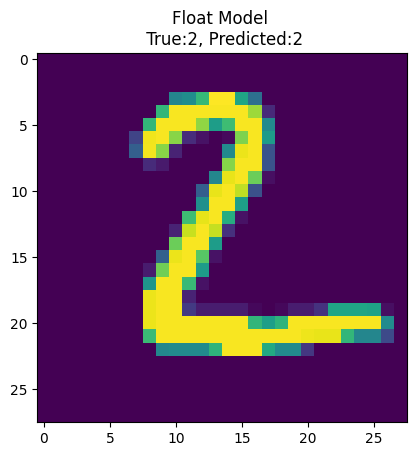

In [13]:
test_model(tflite_model_file, test_image_index, model_type="Float")

그리고 양자화된 모델을 테스트합니다.

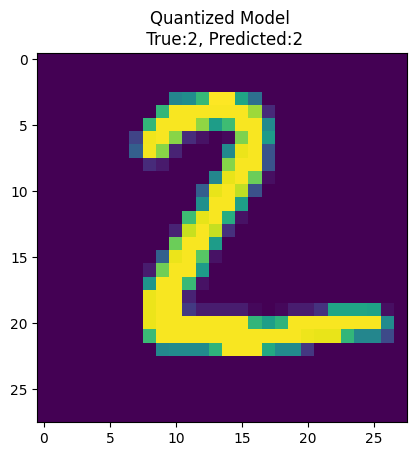

In [14]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

### 모든 이미지에서 모델 평가하기

이제 이 튜토리얼의 시작 부분에서 로드한 모든 테스트 이미지를 사용하여 두 모델을 모두 실행해보겠습니다.

In [15]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

부동 모델을 평가합니다.

In [16]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 97.8000% (Number of test samples=10000)


양자화된 모델을 평가합니다.

In [17]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 97.7700% (Number of test samples=10000)


이제 부동 모델과 비교하여 정확성에 거의 차이가 없는 정수로 모델을 양자화했습니다.

다른 양자화 전략에 대해 자세히 알아 보려면 [TensorFlow Lite 모델 최적화](https://www.tensorflow.org/lite/performance/model_optimization)에 대해 읽어보세요.